In [2]:
from manim import *
import jupyter_capture_output
from numpy import linalg as npl

video_scene = " -v WARNING --disable_caching cat_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cat_Scene"

Manim Community v0.18.0.post0

Jupyter Capture Output v0.0.11


In [48]:
# potential
def get_potential(g, delta):
    def potential(x):
        return g*(g * (x**2-1) * x**2 * (x**2-delta) / (x**2+delta))
    return potential


# verlet maruyama

In [185]:
class CatPotential(Mobject):
    def __init__(self, potential_center = np.array([0, 0, 0]), nline_center = np.array([0, -2, 0]), x_length = 4, y_length = 2, g = 1, delta = 1, **kwargs):
        super().__init__(**kwargs)

        # number plane for potential
        self.npla = NumberPlane(
            x_range = [-1.3, 1.3], y_range = [-0.05, 0.2], x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 1, "stroke_color": GREY}, y_axis_config = {"stroke_opacity": 1, "stroke_color": GREY}, background_line_style = {"stroke_opacity": 0.25, "stroke_color": GRAY}
            ).move_to(potential_center)
        npla_xlabel = self.npla.get_x_axis_label(Tex(r"$x$", font_size = 28, color = BLACK))
        npla_ylabel = self.npla.get_y_axis_label(Tex(r"$V(x)$", font_size = 28, color = BLACK))#.shift(1.05 * LEFT + 0.15 * DOWN)
        
        # draw potential
        self.cat_potential = get_potential(g, delta)
        drawn_potential = self.npla.plot(self.cat_potential, x_range = [-1.15, 1.15], stroke_width = 4, stroke_color = DARK_GREY)
        
        # number line for potential
        self.nline = NumberLine(x_range = [-1.3, 1.3], length = x_length, color = GREY).move_to(nline_center)
        nline_xlabel = Tex(r"$x$", font_size = 28, color = BLACK).next_to(self.nline, 0.5*UR + 0.375*DOWN)

        self.add(self.npla, npla_xlabel, npla_ylabel, self.nline, drawn_potential, nline_xlabel)

        # cat
        self.cat = ImageMobject("external_media/cat1.png")

    
    def get_cat(self, x):
        Vx = self.cat_potential(x)
        V_circle = Circle(radius = 0.05, color = BLACK).move_to(self.npla.c2p(x, Vx))
        Cat = self.cat.move_to(self.nline.n2p(x))
        connector = DashedLine(start = self.npla.c2p(x, Vx), end = self.nline.n2p(x), stroke_color = BLACK, dash_length = 0.05, dashed_ratio = 0.5)
        return [Cat, VGroup(V_circle, connector)]


class CatPosition(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), x_length = 4, y_length = 2, **kwargs):
        super().__init__(**kwargs)

        # number plane for postion over time
        self.npla = NumberPlane(
            x_range = [0, 10], y_range = [-1.3, 1.3], x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 1, "stroke_color": GREY}, y_axis_config = {"stroke_opacity": 1, "stroke_color": GREY}, background_line_style = {"stroke_opacity": 0.25, "stroke_color": GREY}
        ).move_to(center)
        npla_xlabel = self.npla.get_x_axis_label(Tex(r"$t$", font_size = 28, color = BLACK))
        npla_ylabel = self.npla.get_y_axis_label(Tex(r"$x$", font_size = 28, color = BLACK))#.shift(1.05 * LEFT + 0.15 * DOWN)
        self.add(self.npla, npla_xlabel, npla_ylabel)

    def c2p(self, x, y):
        return self.npla.c2p(x, y)
    

Output saved by creating file at animations/cat_behaviour/cat_behaviour.mp4.


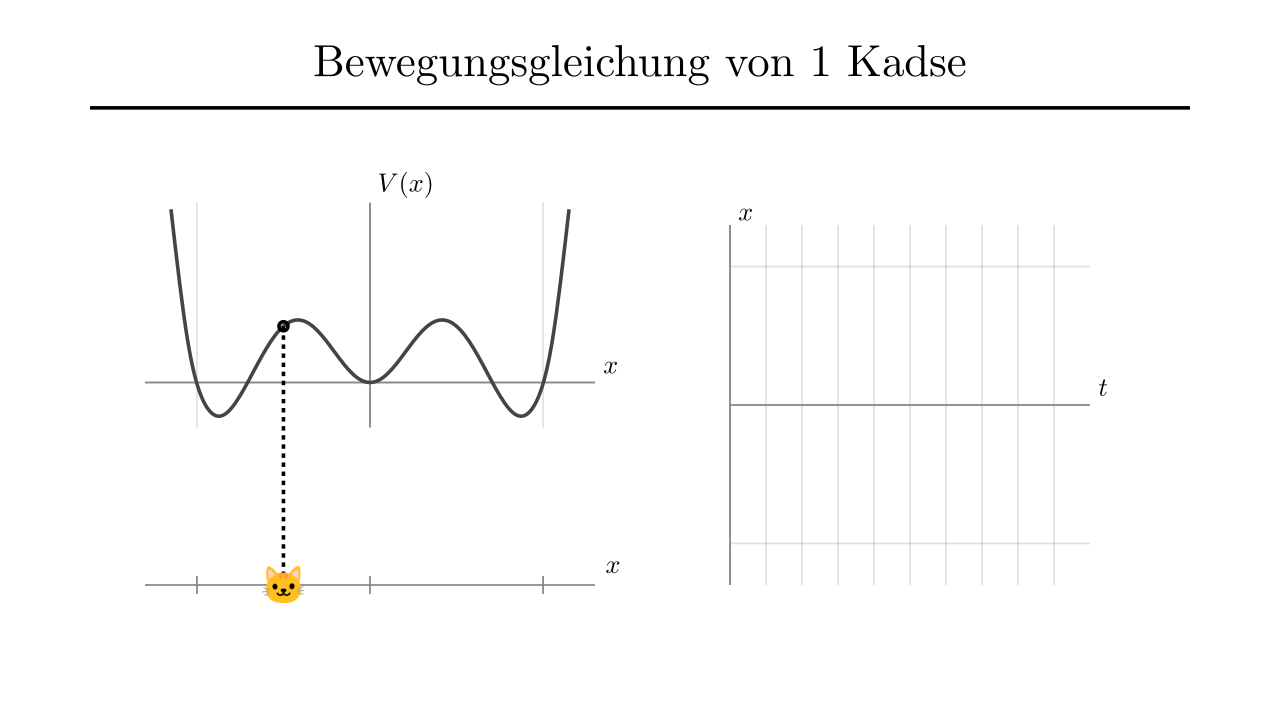

In [186]:
%%capture_video --path "animations/cat_behaviour/cat_behaviour.mp4"
%%manim -qm --fps 60 $video_scene


class cat_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        headline = Title(r"Bewegungsgleichung von 1 Kadse", font_size = 48, color = BLACK).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT)
        headline.underline.set_color(BLACK)
        self.add(headline)

        # left side
        x_center = -3
        potential = CatPotential(potential_center = np.array([x_center, 0.5, 0]), nline_center = np.array([x_center, -2.5, 0]), x_length = 5, y_length = 2.5, g = 1, delta = 0.5)
        cat = potential.get_cat(-0.5)
        self.add(potential, cat[1], cat[0])

        # right side
        position_time = CatPosition(center = np.array([3, -0.5, 0]), x_length = 4, y_length = 4)
        self.add(position_time)
